# Sarcasm Detector

## Get and Load Data

In [ ]:
!pip install --upgrade --no-cache-dir gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install contractions
!pip install textsearch
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 10.8 MB/s 
     |████████████████████████████████| 287 kB 54.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown --id 1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1ytPDo88FEC2ArOjdqErAiarAZBNJzEJz
To: /content/SarcasmDetect.json
100% 6.06M/6.06M [00:00<00:00, 35.7MB/s]


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
import nltk

In [ ]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

In [ ]:
import pandas as pd

df = pd.read_json('./SarcasmDetect.json', lines=True)
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


## Remove all records with no headline text

In [ ]:
df = df[df['headline'] != '']
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28619 entries, 0 to 28618
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   is_sarcastic  28619 non-null  int64 
 1   headline      28619 non-null  object
 2   article_link  28619 non-null  object
dtypes: int64(1), object(2)
memory usage: 894.3+ KB


In [ ]:
df = df[['is_sarcastic', 'headline']]

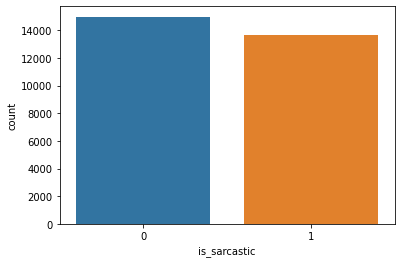

In [ ]:
sns.countplot(x = 'is_sarcastic', data = df);

In [ ]:
from sklearn.model_selection import train_test_split

X = np.array(df['headline'])
y = np.array(df['is_sarcastic'])

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 
X_train, X_valid, y_train, y_valid = train_test_split(X_train_val, y_train_val, random_state=42, test_size=0.3)

print(X_train.shape), print(y_train.shape)
print(X_valid.shape), print(y_valid.shape)
print(X_test.shape), print(y_test.shape)

(14023,)
(14023,)
(6010,)
(6010,)
(8586,)
(8586,)


(None, None)

In [ ]:
# X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) 
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, random_state=42, test_size=0.3)

# print(X_train.shape), print(y_train.shape)
# print(X_valid.shape), print(y_valid.shape)
# print(X_test.shape), print(y_test.shape)

In [ ]:
import nltk
import contractions
import re
import tqdm


def normalize_document(doc):
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', ' ', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  

    return doc

def normalize_corpus(docs):
    norm_docs = []
    for doc in tqdm.tqdm(docs):
        norm_doc = normalize_document(doc)
        norm_docs.append(norm_doc)

    return norm_docs


In [ ]:
X_train_norm = normalize_corpus(X_train)
X_test_norm = normalize_corpus(X_test)
X_valid_norm = normalize_corpus(X_valid)

100%|██████████| 6010/6010 [00:00<00:00, 23763.69it/s]


In [ ]:
#### Tokenizing text to create vocabulary ####

from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents to create the vocabulary of unique words and map them to row numbers in the embedding layer
# Only passed to the train, not the test
tokenizer.fit_on_texts(X_train_norm)
tokenizer.word_index['<PAD>'] = 0

In [ ]:
print("Vocabulary size={}".format(len(tokenizer.word_index)))
print("Number of Documents={}".format(tokenizer.document_count))

Vocabulary size=18769
Number of Documents=14023


In [ ]:
#### Convert texts (sequences of words) to sequence of numeric ids ####

X_train_sequences = tokenizer.texts_to_sequences(X_train_norm)
X_test_sequences = tokenizer.texts_to_sequences(X_test_norm)
X_valid_sequences = tokenizer.texts_to_sequences(X_valid_norm)

print(len(X_train_sequences))
print(len(X_test_sequences))
print(len(X_valid_sequences))

14023
8586
6010


(0.0, 40.0)

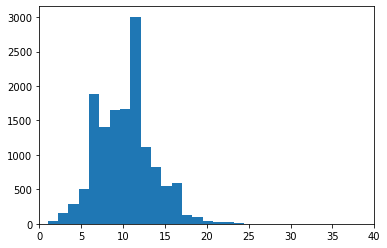

In [ ]:
#### Visualizing sentence length distribution ####

plt.hist([len(doc.split()) for doc in X_train_norm], bins=30);
plt.xlim([0, 40])

In [ ]:
#### Padding text sequences ####

MAX_SEQUENCE_LENGTH = 25

# pad dataset to a maximum review length in words
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_valid_padded = tf.keras.preprocessing.sequence.pad_sequences(X_valid_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train_padded.shape, X_test_padded.shape, X_valid_padded.shape

((14023, 25), (8586, 25), (6010, 25))

## FastText Embeddings

In [ ]:
### Download Pre-trained FastText Embeddings
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip

--2022-06-24 12:35:45--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M-subword.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.75.142, 104.22.74.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5828358084 (5.4G) [application/zip]
Saving to: ‘crawl-300d-2M-subword.zip’

crawl-300d-2M-subwo 100%[===================>]   5.43G  52.6MB/s    in 1m 48s  

2022-06-24 12:37:34 (51.4 MB/s) - ‘crawl-300d-2M-subword.zip’ saved [5828358084/5828358084]



In [ ]:
!unzip crawl-300d-2M-subword.zip

Archive:  crawl-300d-2M-subword.zip
  inflating: crawl-300d-2M-subword.vec  
  inflating: crawl-300d-2M-subword.bin  


In [ ]:
### Generate Pre-trained Embedding Matrix
def load_pretrained_embeddings(word_to_index, max_features, embedding_size, embedding_file_path):    
    
    def get_coefs(word,*arr): 
        return word, np.asarray(arr, dtype='float32')
    
    embeddings_index = dict(get_coefs(*row.split(" ")) 
                                for row in open(embedding_file_path, encoding="utf8", errors='ignore') 
                                    if len(row)>100)

    all_embs = np.stack(embeddings_index.values())
    emb_mean, emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_to_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embedding_size))
    
    for word, idx in word_to_index.items():
        if idx >= max_features: 
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [ ]:
vocabulary_size = len(tokenizer.word_index)
embedding_size = 300

ft_embeddings = load_pretrained_embeddings(word_to_index = tokenizer.word_index, 
                                           max_features = vocabulary_size, 
                                           embedding_size = embedding_size, 
                                           embedding_file_path = './crawl-300d-2M-subword.vec')
ft_embeddings.shape

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


(18769, 300)

## CNN Model Training

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding

In [ ]:
# Model creation
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Embedding(vocabulary_size, embedding_size,
                                    weights=[ft_embeddings],
                                    trainable=True,
                                    input_length=MAX_SEQUENCE_LENGTH))
tf.keras.layers.Dropout(0.2),

model.add(tf.keras.layers.Conv1D(filters=256, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=5, padding='same', activation='relu'))
tf.keras.layers.GlobalAveragePooling1D(),

model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(pool_size=2))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 300)           5630700   
                                                                 
 conv1d (Conv1D)             (None, 25, 256)           384256    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 12, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 12, 128)           163968    
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 64)            41024     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 64)            0         
 1D)                                                    

In [ ]:
# Fitting the model

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=5,
                                      restore_best_weights=True,
                                      verbose=1)

model.fit(X_train_padded, y_train, 
          validation_data=(X_valid_padded, y_valid),
          epochs=100, 
          batch_size=128, 
          shuffle=True,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/100
110/110 [==============================] - 14s 13ms/step - loss: 0.4493 - accuracy: 0.7789 - val_loss: 0.3308 - val_accuracy: 0.8566
Epoch 2/100
110/110 [==============================] - 1s 11ms/step - loss: 0.1667 - accuracy: 0.9391 - val_loss: 0.3466 - val_accuracy: 0.8552
Epoch 3/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0490 - accuracy: 0.9850 - val_loss: 0.6424 - val_accuracy: 0.8494
Epoch 4/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0229 - accuracy: 0.9926 - val_loss: 0.8041 - val_accuracy: 0.8522
Epoch 5/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0114 - accuracy: 0.9959 - val_loss: 0.8800 - val_accuracy: 0.8476
Epoch 6/100
110/110 [==============================] - 1s 10ms/step - loss: 0.0081 - accuracy: 0.9974 - val_loss: 0.8189 - val_accuracy: 0.8464
Epoch 6: early stopping


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

predictions = model.predict(X_test_padded, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 85.58%
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      4496
           1       0.88      0.81      0.84      4090

    accuracy                           0.86      8586
   macro avg       0.86      0.85      0.85      8586
weighted avg       0.86      0.86      0.86      8586



,0,1
0,4050,446
1,792,3298


## NNLM Model

In [ ]:
model_nnlm = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(model_nnlm, output_shape=[128], input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model_nnlm = tf.keras.models.Sequential()
model_nnlm.add(hub_layer)
model_nnlm.add(tf.keras.layers.Dense(128, activation='relu'))
model_nnlm.add(tf.keras.layers.Dropout(0.25))
model_nnlm.add(tf.keras.layers.Dense(128, activation='relu'))
model_nnlm.add(tf.keras.layers.Dropout(0.25))
model_nnlm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_nnlm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nnlm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 124,675,841
Trainable params: 124,675,84

In [ ]:
model_nnlm.fit(np.array(X_train_norm), y_train, 
          validation_data=(np.array(X_valid_norm), y_valid),
          epochs=100, 
          batch_size=128, 
          shuffle=True,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/100
110/110 [==============================] - 6s 46ms/step - loss: 0.4579 - accuracy: 0.7960 - val_loss: 0.3378 - val_accuracy: 0.8522
Epoch 2/100
110/110 [==============================] - 4s 38ms/step - loss: 0.2195 - accuracy: 0.9142 - val_loss: 0.3611 - val_accuracy: 0.8502
Epoch 3/100
110/110 [==============================] - 4s 38ms/step - loss: 0.1084 - accuracy: 0.9626 - val_loss: 0.4460 - val_accuracy: 0.8434
Epoch 4/100
110/110 [==============================] - 4s 39ms/step - loss: 0.0529 - accuracy: 0.9831 - val_loss: 0.5746 - val_accuracy: 0.8366
Epoch 5/100
110/110 [==============================] - 4s 38ms/step - loss: 0.0238 - accuracy: 0.9926 - val_loss: 0.7611 - val_accuracy: 0.8341
Epoch 6/100
110/110 [==============================] - 4s 40ms/step - loss: 0.0134 - accuracy: 0.9955 - val_loss: 0.8470 - val_accuracy: 0.8336
Epoch 6: early stopping


In [ ]:
predictions = model_nnlm.predict(X_test_norm, batch_size=2048, verbose=0).ravel()
predictions = [1 if prob > 0.5 else 0 for prob in predictions]
print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 84.91%
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      4496
           1       0.86      0.82      0.84      4090

    accuracy                           0.85      8586
   macro avg       0.85      0.85      0.85      8586
weighted avg       0.85      0.85      0.85      8586



,0,1
0,3928,568
1,728,3362


# DistilBERT Model

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 8.5 MB/s 
     |████████████████████████████████| 101 kB 12.3 MB/s 
     |████████████████████████████████| 596 kB 69.5 MB/s 
     |████████████████████████████████| 6.6 MB 22.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import transformers

tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [ ]:
def create_bert_input_features(tokenizer, docs, max_seq_length):
    
    all_ids, all_masks = [], []
    for doc in tqdm.tqdm(docs, desc="Converting docs to features"):
        
        tokens = tokenizer.tokenize(doc)
        
        if len(tokens) > max_seq_length-2:
            tokens = tokens[0 : (max_seq_length-2)]
        tokens = ['[CLS]'] + tokens + ['[SEP]']
        ids = tokenizer.convert_tokens_to_ids(tokens)
        masks = [1] * len(ids)
        
        # Zero-pad up to the sequence length.
        while len(ids) < max_seq_length:
            ids.append(0)
            masks.append(0)
            
        all_ids.append(ids)
        all_masks.append(masks)
        
    encoded = np.array([all_ids, all_masks])
    
    return encoded

In [ ]:
MAX_SEQ_LENGTH = 25

train_features_ids, train_features_masks = create_bert_input_features(tokenizer, X_train_norm, max_seq_length=MAX_SEQ_LENGTH)
val_features_ids, val_features_masks = create_bert_input_features(tokenizer, X_valid_norm, max_seq_length=MAX_SEQ_LENGTH)
test_features_ids, test_features_masks = create_bert_input_features(tokenizer, X_test_norm, max_seq_length=MAX_SEQ_LENGTH)


print('Train Features:', train_features_ids.shape, train_features_masks.shape)
print('Val Features:', val_features_ids.shape, val_features_masks.shape)
print('Test Features:', test_features_ids.shape, test_features_masks.shape)

Converting docs to features: 100%|██████████| 8586/8586 [00:07<00:00, 1143.28it/s]


Train Features: (14023, 25) (14023, 25)
Val Features: (6010, 25) (6010, 25)
Test Features: (8586, 25) (8586, 25)


In [ ]:
# Model

inp_id = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_ids")
inp_mask = tf.keras.layers.Input(shape=(MAX_SEQ_LENGTH,), dtype='int32', name="bert_input_masks")
inputs = [inp_id, inp_mask]

hidden_state = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')(inputs)[0]
pooled_output = hidden_state[:, 0]    

dense1 = tf.keras.layers.Dense(256, activation='relu')(pooled_output)
drop1 = tf.keras.layers.Dropout(0.25)(dense1)

dense2 = tf.keras.layers.Dense(256, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(0.25)(dense2)

# dense3 = tf.keras.layers.Dense(256, activation='relu')(drop2)
# drop3 = tf.keras.layers.Dropout(0.25)(dense3)

output = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model_distilbart = tf.keras.Model(inputs=inputs, outputs=output)
model_distilbart.compile(optimizer=tf.optimizers.Adam(learning_rate=5e-5, 
                                           epsilon=1e-08), 
              loss='binary_crossentropy', metrics=['accuracy'])

model_distilbart.summary()

Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'activation_13', 'vocab_layer_norm', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 bert_input_ids (InputLayer)    [(None, 25)]         0           []                               
                                                                                                  
 bert_input_masks (InputLayer)  [(None, 25)]         0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['bert_input_ids[0][0]',         
 BertModel)                     ast_hidden_state=(N               'bert_input_masks[0][0]']       
                                one, 25, 768),                                                    
                                 hidden_states=None                                           

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                      patience=3,
                                      restore_best_weights=True,
                                      verbose=1)

model_distilbart.fit([train_features_ids, 
           train_features_masks], y_train, 
           validation_data=([val_features_ids, 
                            val_features_masks], y_valid),
          epochs=10, 
          batch_size=64, 
          shuffle=True,
          callbacks=[early_stopping],
          verbose=1)

Epoch 1/10
220/220 [==============================] - 54s 167ms/step - loss: 0.3420 - accuracy: 0.8482 - val_loss: 0.2353 - val_accuracy: 0.9000
Epoch 2/10
220/220 [==============================] - 30s 138ms/step - loss: 0.1517 - accuracy: 0.9427 - val_loss: 0.2577 - val_accuracy: 0.9111
Epoch 3/10
220/220 [==============================] - 31s 143ms/step - loss: 0.0539 - accuracy: 0.9822 - val_loss: 0.3392 - val_accuracy: 0.9015
Epoch 4/10
220/220 [==============================] - 31s 141ms/step - loss: 0.0296 - accuracy: 0.9907 - val_loss: 0.3860 - val_accuracy: 0.9002
Epoch 4: early stopping


In [ ]:
model_distilbart.save_weights('distillbert_ft_wts.h5')

In [44]:
predictions = [1 if pr > 0.5 else 0 
                   for pr in model_distilbart.predict([test_features_ids, 
                                            test_features_masks], batch_size=100, verbose=0).ravel()]

print("Accuracy: %.2f%%" % (accuracy_score(y_test, predictions)*100))
print(classification_report(y_test, predictions))
pd.DataFrame(confusion_matrix(y_test, predictions))

Accuracy: 90.10%
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      4496
           1       0.90      0.90      0.90      4090

    accuracy                           0.90      8586
   macro avg       0.90      0.90      0.90      8586
weighted avg       0.90      0.90      0.90      8586



,0,1
0,4070,426
1,424,3666
